<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Graph%20Neural%20Network/Light_GCN_Supervised_Task_using_GNN_and_PyTorch%2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import required modules

In [26]:

import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

In [9]:
movie_path = '/content/movies.csv'
rating_path = '/content/ratings.csv'

In [10]:
rating_df = pd.read_csv(rating_path)

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [11]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

667
10324


In [12]:
# load edges between users and movies
def load_edge_csv(df,
                  src_index_col,
                  dst_index_col,
                  link_index_col,
                  rating_threshold=3.5):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """

    edge_index = None
    src = [user_id for user_id in  df['userId']]

    num_users = len(df['userId'].unique())

    dst = [(movie_id) for movie_id in df['movieId']]

    link_vals = df[link_index_col].values

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_values = []

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            edge_values.append(link_vals[i])

    # edge_values is the label we will use for compute training loss
    return edge_index, edge_values

In [13]:
edge_index, edge_values = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=1 # need to use threshold=1 so the model can learn based on RMSE
)

In [14]:
# Convert to tensor
edge_index = torch.LongTensor(edge_index)
edge_values = torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

tensor([[    0,     0,     0,  ...,   667,   667,   667],
        [   15,    23,    31,  ..., 10312, 10317, 10323]])
torch.Size([2, 104141])
tensor([4.0000, 1.5000, 4.0000,  ..., 4.0000, 2.5000, 4.5000],
       dtype=torch.float64)
torch.Size([104141])


In [15]:
# split the edges of the graph using a 80/10/10 train/validation/test split
# num_users, num_movies = len(user_mapping), len(movie_mapping)

num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

print(f"num_users {num_users}, num_movies {num_movies}")

num_users 668, num_movies 10325


In [16]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)

    # create adj_matrix
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()

    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [17]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):

    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                           col=input_edge_index[1],
                                           value = input_edge_values,
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))

    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]

    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()

    return r_mat_edge_index, r_mat_edge_values

In [18]:
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices,
                                               test_size=0.2,
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices,
                                             test_size=0.5,
                                             random_state=1)

In [19]:
train_edge_index = edge_index[:, train_indices]
train_edge_value = edge_values[train_indices]

val_edge_index = edge_index[:, val_indices]
val_edge_value = edge_values[val_indices]

test_edge_index = edge_index[:, test_indices]
test_edge_value = edge_values[test_indices]

In [20]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

print(test_edge_value)
print(test_edge_value.size())

num_users 668, num_movies 10325, num_interactions 104141
train_edge_index tensor([[ 330,  606,  562,  ...,   59,  554,  666],
        [5437, 2457,  725,  ..., 2487,  129, 3988]])
10993
torch.Size([668])
torch.Size([9473])
tensor([4.5000, 3.0000, 5.0000,  ..., 2.5000, 3.0000, 3.5000],
       dtype=torch.float64)
torch.Size([10415])


In [21]:
train_edge_index, train_edge_values  = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_value)

In [22]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n {train_edge_values} \n {train_edge_values.size()}")
print(f"\n val_edge_values: \n {val_edge_values} \n {val_edge_values.size()}")
print(f"\n test_edge_values: \n {test_edge_values} \n {test_edge_values.size()}")

tensor([[    0,     0,     0,  ..., 10991, 10991, 10992],
        [  683,   699,   712,  ...,   575,   667,   474]])
torch.Size([2, 166624])
tensor([[    0,     0,     0,  ..., 10949, 10951, 10961],
        [  691,   794,   809,  ...,   605,   457,   160]])
torch.Size([2, 20828])
tensor([[    0,     0,     0,  ..., 10978, 10979, 10990],
        [  715,   898,   928,  ...,   588,   166,   474]])
torch.Size([2, 20830])

 train_edge_values: 
 tensor([4.0000, 4.0000, 4.0000,  ..., 4.5000, 4.5000, 4.0000]) 
 torch.Size([166624])

 val_edge_values: 
 tensor([1.5000, 3.0000, 3.0000,  ..., 5.0000, 4.0000, 3.0000]) 
 torch.Size([20828])

 test_edge_values: 
 tensor([4.0000, 4.5000, 4.0000,  ..., 3.0000, 4.0000, 3.0000]) 
 torch.Size([20830])


Implementing LightGCN

In [27]:
# defines LightGCN model
class LightGCN(MessagePassing):



    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops



        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0

        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0


        # "Fills the input Tensor with values drawn from the normal distribution"

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

        # create a linear layer (fully connected layer) so we can output a single value (predicted_rating)
        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

    def forward(self, edge_index: Tensor, edge_values: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """


        edge_index_norm = gcn_norm(edge_index=edge_index,
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list

        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)




        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len.
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)


        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(emb_final,
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K


        r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)

        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]

        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]

        # output dim: edge_index_len x 128 (given 64 is the original emb_vector_len)
        output = torch.cat([user_embeds, item_embeds], dim=1)

        # push it through the linear layer
        output = self.out(output)

        return output

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

layers = 1
model = LightGCN(num_users=num_users,
                 num_items=num_movies,
                 K=layers)

Training

Your test set performance should be in line with the following (K=20):

In [28]:
# define constants
ITERATIONS = 10000
EPOCHS = 10

BATCH_SIZE = 1024

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 10
LAMBDA = 1e-6

In [29]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [30]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

# add decay to avoid overfit
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)


loss_func = nn.MSELoss()

Using device cpu.


In [31]:
def get_recall_at_k(input_edge_index,
                     input_edge_values, # the true label of actual ratings for each user/item interaction
                     pred_ratings, # the list of predicted ratings
                     k=10,
                     threshold=3.5):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)

        for i in range(len(input_edge_index[0])):
            src = input_edge_index[0][i].item()
            dest = input_edge_index[1][i].item()
            true_rating = input_edge_values[i].item()
            pred_rating = pred_ratings[i].item()

            user_item_rating_list[src].append((pred_rating, true_rating))

        recalls = dict()
        precisions = dict()

        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        overall_recall = sum(rec for rec in recalls.values()) / len(recalls)
        overall_precision = sum(prec for prec in precisions.values()) / len(precisions)

        return overall_recall, overall_precision


In [32]:
r_mat_train_edge_index, r_mat_train_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index, train_edge_values)
r_mat_val_edge_index, r_mat_val_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index, val_edge_values)
r_mat_test_edge_index, r_mat_test_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index, test_edge_values)


In [33]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation

    # the rating here is based on r_mat
    pred_ratings = model.forward(train_edge_index, train_edge_values)


    train_loss = loss_func(pred_ratings, r_mat_train_edge_values.view(-1,1))


    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # going over validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index, val_edge_values)

            val_loss = loss_func(val_pred_ratings, r_mat_val_edge_values.view(-1,1)).sum()

            recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_edge_index,
                                                          r_mat_val_edge_values,
                                                          val_pred_ratings,
                                                          k = 20
                                                         )


            val_recall_at_ks.append(round(recall_at_k, 5))
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())

            print(f"[Iteration {iter}/{ITERATIONS}], train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)},  recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

[Iteration 0/10000], train_loss: 13.99255, val_loss: 13.95941,  recall_at_k 0.0, precision_at_k 0.0
[Iteration 200/10000], train_loss: 2.61201, val_loss: 2.6778,  recall_at_k 0.00941, precision_at_k 0.08188
[Iteration 400/10000], train_loss: 1.64229, val_loss: 1.68982,  recall_at_k 0.06244, precision_at_k 0.25535
[Iteration 600/10000], train_loss: 1.37101, val_loss: 1.41843,  recall_at_k 0.11129, precision_at_k 0.35762
[Iteration 800/10000], train_loss: 1.23284, val_loss: 1.28126,  recall_at_k 0.14269, precision_at_k 0.40309
[Iteration 1000/10000], train_loss: 1.1457, val_loss: 1.19531,  recall_at_k 0.16594, precision_at_k 0.42498
[Iteration 1200/10000], train_loss: 1.08445, val_loss: 1.13514,  recall_at_k 0.18331, precision_at_k 0.4366
[Iteration 1400/10000], train_loss: 1.03848, val_loss: 1.09006,  recall_at_k 0.20047, precision_at_k 0.45154
[Iteration 1600/10000], train_loss: 1.00245, val_loss: 1.0547,  recall_at_k 0.21024, precision_at_k 0.45598
[Iteration 1800/10000], train_loss: 

Plot (RMSE)

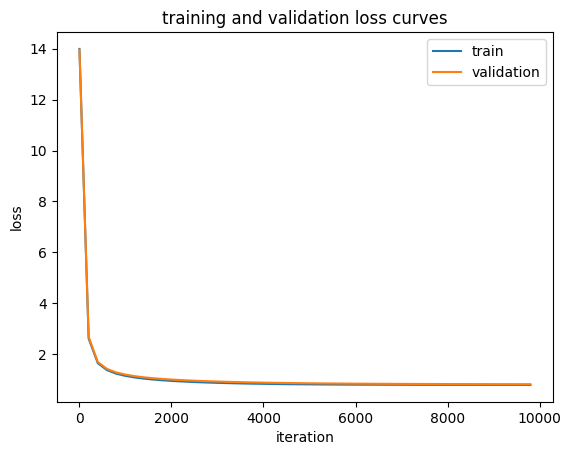

In [34]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

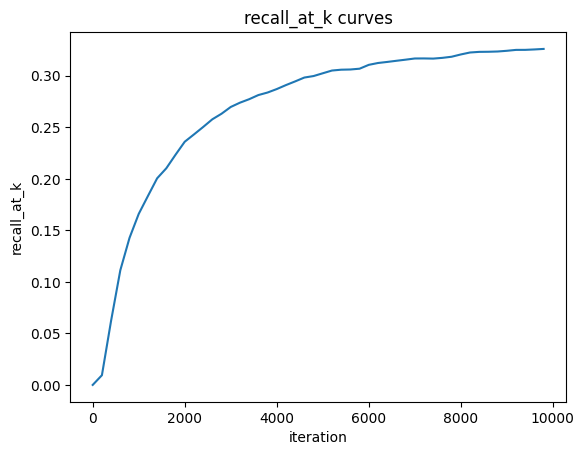

In [36]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

Evaluation (RMSE)

In [37]:
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_edge_index, test_edge_values)
    recall_at_k, precision_at_k = get_recall_at_k(r_mat_test_edge_index,
                                                  r_mat_test_edge_values,
                                                  pred_ratings, 20)
    print(f"recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

recall_at_k 0.32359, precision_at_k 0.54308
